# Thư viện

In [1]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 6.6 MB/s eta 0:00:00


In [2]:
#Restart session required
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 22.8 MB/s eta 0:00:00


In [3]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
from PIL import Image
from transformers import Blip2ForConditionalGeneration, Blip2Processor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import torch
from datasets import Dataset

# Load mô hình (int8) và convert sang PEFT

In [5]:
quant_config = BitsAndBytesConfig(load_in_8bit=True)

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", quantization_config=quant_config)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


In [7]:
for param in model.vision_model.parameters():
    param.requires_grad = False

In [8]:
class ImageCaptioningDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["caption"] = item["caption"]
        return encoding

def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "caption":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["caption"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

# Xử lý dữ liệu

In [9]:
dataset_path = '/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset'

In [10]:
def load_data(path):
    with open(path + 'captions.txt', 'r', encoding='utf-8') as file:
        lines = file.readlines()

    data = [line.split('\t', 1) for line in lines]
    df = pd.DataFrame(data, columns=["image_path", "caption"])

    return df

In [11]:
train_path = dataset_path + '/train/'
val_path = dataset_path + '/val/'
test_path = dataset_path + '/test/'

df_train = load_data(train_path)
df_val = load_data(val_path)
df_test = load_data(test_path)

In [12]:
from pyvi import ViUtils, ViTokenizer

def text_preprocessing(text):
    text = ViTokenizer.tokenize(text)
    text = text.replace('\n', ' ')
    text = ViUtils.remove_accents(text)
    text = text.decode("utf-8")
    text = text.replace("'", "")
    text = text.lstrip('b')
    return text

In [13]:
df_train['caption'] = df_train['caption'].apply(lambda x: text_preprocessing(x))
df_val['caption'] = df_val['caption'].apply(lambda x: text_preprocessing(x))
df_test['caption'] = df_test['caption'].apply(lambda x: text_preprocessing(x))

In [14]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

In [15]:
dataset_path_2 = '/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/'

def load_image(image_path):
  image_path = dataset_path_2 + image_path
  return Image.open(image_path)

In [16]:
train_dataset = train_dataset.map(lambda example: {"image": load_image(example["image_path"])}, batched=False)

Map:   0%|          | 0/13481 [00:00<?, ? examples/s]

In [17]:
train_dataset = train_dataset.remove_columns(["image_path"])

In [18]:
val_dataset = val_dataset.map(lambda example: {"image": load_image(example["image_path"])}, batched=False)
val_dataset = val_dataset.remove_columns(["image_path"])

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

In [19]:
train_dataset = ImageCaptioningDataset(train_dataset, processor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

In [20]:
val_dataset = ImageCaptioningDataset(val_dataset, processor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

In [21]:
import torch
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

best_val_loss = float('inf')
best_model_path = "best_model.pth"
epochs_no_improve = 0
n_epochs_stop = 2
max_epochs = 30

for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")

    # Training Phase
    model.train()
    epoch_train_loss = 0
    with tqdm(train_dataloader, desc=f"Epoch {epoch + 1} (Train)", unit="batch") as tepoch:
        for idx, batch in enumerate(tepoch):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device, dtype=torch.float32)

            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)

            loss = outputs.loss
            epoch_train_loss += loss.item()

            tepoch.set_postfix(loss=loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    print(f"Average training loss for epoch {epoch + 1}: {avg_train_loss:.4f}")

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        with tqdm(val_dataloader, desc=f"Epoch {epoch + 1} (Val)", unit="batch") as vepoch:
            for idx, batch in enumerate(vepoch):
                input_ids = batch.pop("input_ids").to(device)
                pixel_values = batch.pop("pixel_values").to(device, dtype=torch.float32)

                outputs = model(input_ids=input_ids,
                                pixel_values=pixel_values,
                                labels=input_ids)

                loss = outputs.loss
                epoch_val_loss += loss.item()

                vepoch.set_postfix(loss=loss.item())

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    print(f"Average validation loss for epoch {epoch + 1}: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved to {best_model_path} with validation loss: {best_val_loss:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epochs.")

    if epochs_no_improve == n_epochs_stop:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

print("Training finished.")

Epoch 1/10


Epoch 1 (Train): 100%|██████████| 4494/4494 [45:39<00:00,  1.64batch/s, loss=1.11]


Average training loss for epoch 1: 1.1796


Epoch 1 (Val): 100%|██████████| 1540/1540 [11:25<00:00,  2.25batch/s, loss=0.764]


Average validation loss for epoch 1: 1.0956
Model saved to best_model.pth with validation loss: 1.0956
Epoch 2/10


Epoch 2 (Train): 100%|██████████| 4494/4494 [45:30<00:00,  1.65batch/s, loss=2.56]


Average training loss for epoch 2: 1.3236


Epoch 2 (Val): 100%|██████████| 1540/1540 [11:19<00:00,  2.27batch/s, loss=2.42]


Average validation loss for epoch 2: 2.2081
Validation loss did not improve for 1 epochs.
Epoch 3/10


Epoch 3 (Train): 100%|██████████| 4494/4494 [45:56<00:00,  1.63batch/s, loss=4.46]


Average training loss for epoch 3: 2.9322


Epoch 3 (Val): 100%|██████████| 1540/1540 [11:26<00:00,  2.24batch/s, loss=4.53]

Average validation loss for epoch 3: 4.1525
Validation loss did not improve for 2 epochs.
Early stopping triggered after 3 epochs.
Training finished.


In [22]:
test_dataset = Dataset.from_pandas(df_test)
test_dataset = test_dataset.map(lambda example: {"image": load_image(example["image_path"])}, batched=False)

Map:   0%|          | 0/1155 [00:00<?, ? examples/s]

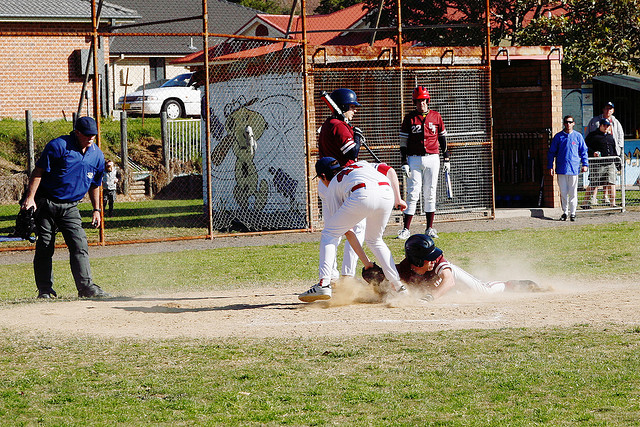

In [23]:
example = test_dataset[20]
image = example["image"]
image

In [24]:
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.


In [25]:
generated_caption

'Mot_ch_ch_bong_ch_ch dang ch     dong b'